## My approach to Kaggle's LANL Earthquake Prediction
Welcome! In this notebook I will go over my approach to my first [Kaggle competition](https://www.kaggle.com/c/LANL-Earthquake-Prediction).  
I will go over my thought process, my results, and the lessons that I have learned.

In [1]:
import os
import numpy as np
from pandas import read_csv
import matplotlib.pyplot as plt
import pywt
from dtsckit.utils import read_pickle
from lanl.dataset import get_quake_indices, get_sample
from lanl.segmenter import SpikeSegmenter, plot_segments
from lanl.spectral import create_spectrogram

### EDA:
- Training data is composed of a single laboratory earthquake simulation with 16 continuous earthquakes
- Each point in the series has an acoustic value along with the time remaining until the next earthquake
- Entire experiment spans a few minutes (the resolution is very high, each time step is ~ 1e-9 seconds)
- The acoustic values seem to have a constant, polulation mean with the variation sporadically spiking
- Each testing segment has only 150000 points and are drawn from simulations independent from the training run
- Task seems hard... predict the next earthquake given a small snippet of acoustic values

In [2]:
ROOT_DIR = '/home/mchobanyan/data/kaggle/lanl_earthquake/'
TRAIN_FILE = os.path.join(ROOT_DIR, 'train.pkl')
df = read_pickle(TRAIN_FILE)
data = df.values
n = len(data)
print(f'Data ready: {n} total timesteps')

Data ready: 629145480 total timesteps


In [3]:
quake_indices = get_quake_indices(df.iloc[:, 1])
print(f'Number of training earthquakes = {len(quake_indices)-1}')

Number of training earthquakes = 16


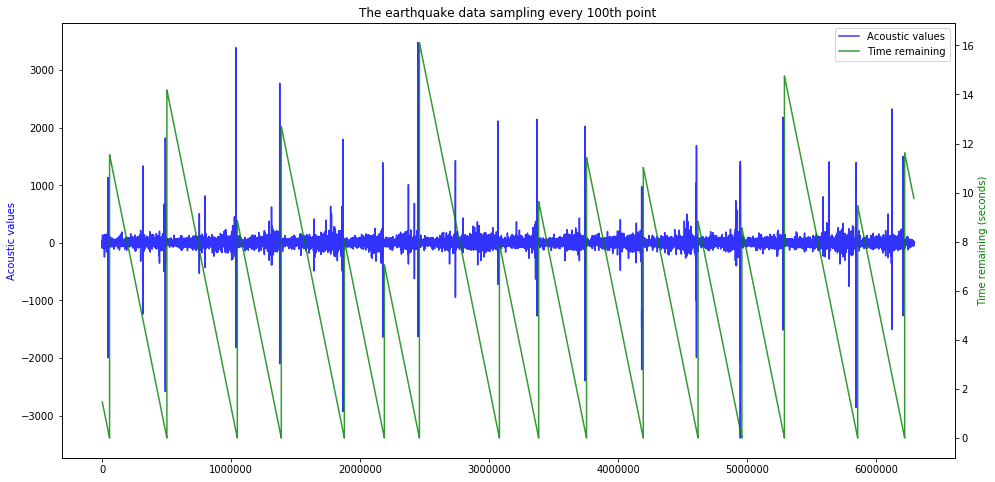

In [4]:
def plot_earthquakes_with_time(acoustic_values, time_remaining, title, figsize=(16, 8)):
    data_idx = np.arange(len(acoustic_values))
    fig, ax1 = plt.subplots(figsize=(16, 8))
    acoustic_plot = ax1.plot(data_idx, acoustic_values, label='Acoustic values', c='blue', alpha=0.8)
    ax1.set_ylabel('Acoustic values', color='blue')

    ax2 = ax1.twinx()
    time_plot = ax2.plot(data_idx, time_remaining, label='Time remaining', c='green', alpha=0.8)
    ax2.set_ylabel('Time remaining (seconds)', color='green')

    plots = acoustic_plot + time_plot
    labels = [plot.get_label() for plot in plots]
    ax1.legend(plots, labels, loc='best')
    plt.title(title)
    plt.show()


plot_earthquakes_with_time(data[::100, 0], data[::100, 1], 'The earthquake data sampling every 100th point')

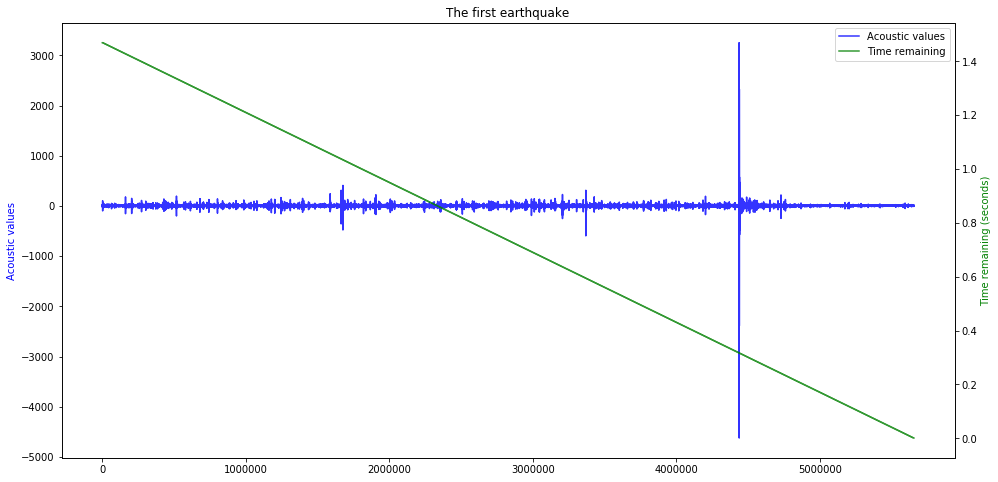

In [5]:
first_earthquake = data[0:quake_indices[1]]
plot_earthquakes_with_time(first_earthquake[:, 0], first_earthquake[:, 1], 'The first earthquake')

Testing segment: 150000 timesteps


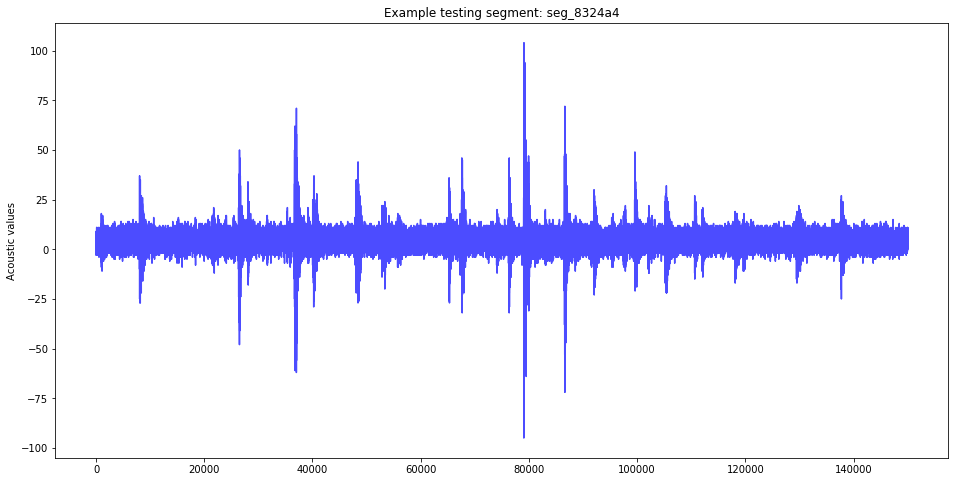

In [6]:
test_segment = read_csv(os.path.join(ROOT_DIR, 'test/seg_8324a4.csv')).values.squeeze()
print(f'Testing segment: {len(test_segment)} timesteps')
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(np.arange(len(test_segment)), test_segment, c='blue', alpha=0.7)
ax.set_ylabel('Acoustic values')
plt.title('Example testing segment: seg_8324a4')
plt.show()

### Approach 1: 
- My first approach was inspired from the following kernel: 
https://www.kaggle.com/mayer79/rnn-starter-for-huge-time-series
- The idea is to create a data loader that serves batches of sampled, continuous acoustic samples
- Each sampled acoustic sequence has 150000 points (same as the test set) and the target time remaining at the end of the sequence
- Each acoustic sequence is then binned into regular intervals, hand engineered features are extracted, and a GRU is applied
- The extracted features are statistics measuring the distribution of acoustic values with focus on the variation
- Example features: quantiles on raw data and absolute value data, skew, kurtosis
- Validation score: **1.68**

### Approach 2:
- My second approach replaced the hand-engineered features with a 1D CNN feature extractor
- I had a feeling that convolutions would serve well here to automatically extract the important features from the local acoustic neighborhoods
- However, it did not lower the validation score

### Approach 3:
- Keeping with the same idea, I wondered if the reason the CNN feature extractor failed is because the data is too noisy
- If the model is overly complex, it may be trying to build features based off of the random noise in the acoustic data
- So I trained a separate convolutional autoencoder and used it as a fixed feature extractor for the GRU.
- Again, this did not help...

### Approach 4:
- After taking some time off, I switched my focus to identifying when the acoustic values are "excited" and spike up
- My intuition was that segmenting the acoustic sequence based on changes in variance would be smarter than just binning at regular intervals
- First, the population $\mu$ and $\sigma$ were estimated by filtering out all acoustic values that exceeded an acoustic threshold (~20)
- Then, the sequence was binned into windows of 300 points. Each window was labeled as excited or not based on a $\mu$ + 2*$\sigma$ margin and adjacent bins of the same type were joined together.
- I kept the original GRU approach with hand engineered features, except the results of the SpikeSegmenter were used instead of regular bins.
- This slightly lowered the validation score to **1.66**.	

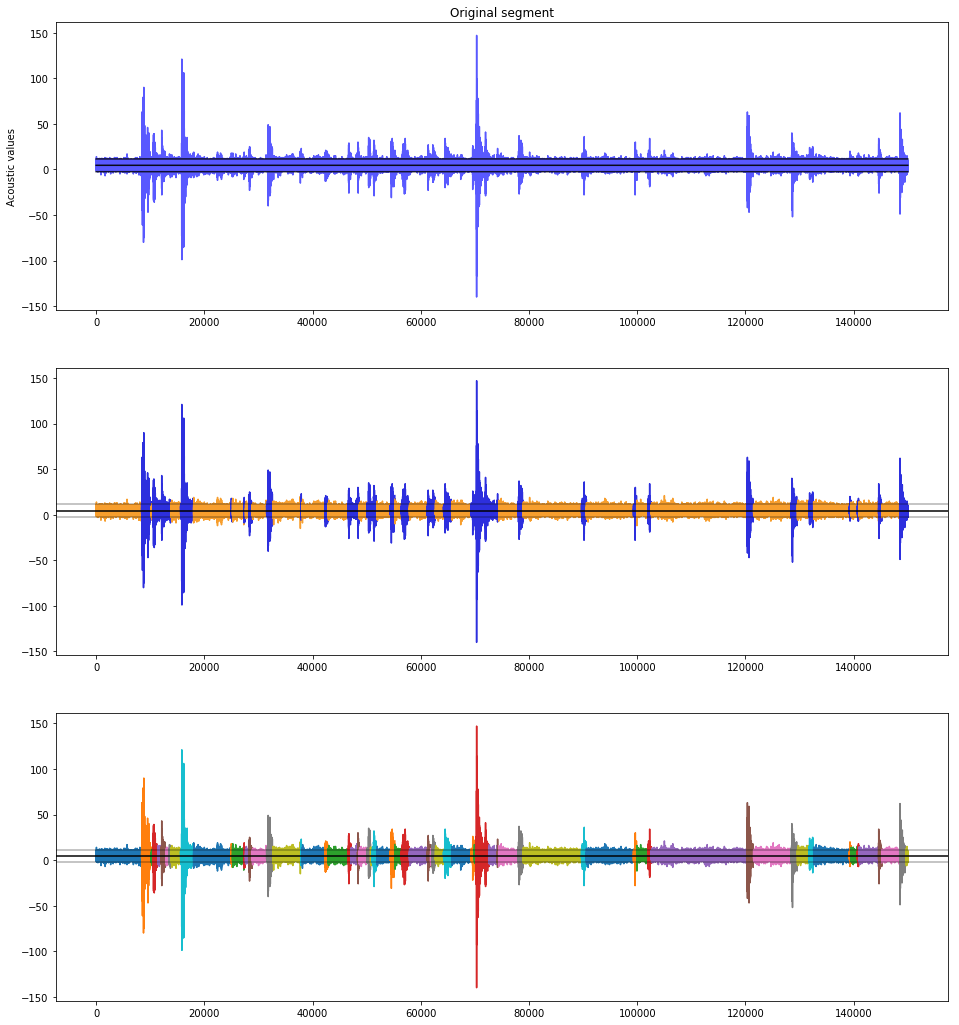

In [9]:
mu = 4.5
sigma = 3.5

# define the segmenter, get an acoustic sample, calculate the cutoffs
segmenter = SpikeSegmenter(mu=3.5, sigma=4.5, window_size=300)
acoustic_sample = get_sample(data, seqlen=150000)[:, 0]
cutoffs = segmenter(acoustic_sample)

# plot the raw signal with a mu +- 2*sigma margin
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 18))
ax1.plot(np.arange(150000), acoustic_sample, c='blue', alpha=0.65)
ax1.plot(np.arange(150000), 150000*[mu], c='black', alpha=0.9)
ax1.plot(np.arange(150000), 150000*[mu+2*sigma], c='black', alpha=0.8)
ax1.plot(np.arange(150000), 150000*[mu-2*sigma], c='black', alpha=0.8)
ax1.set_title('Original segment')
ax1.set_ylabel('Acoustic values')

# plot the results of the segmenter
# blue segments represent "excited" segments, orange represents "normal" behavior
plot_segments(ax2, acoustic_sample, cutoffs, False, mu, sigma, alpha=0.3)

# plot the results of the segmenter again instead this time
# each segment is assigned a random color to get a different visual
plot_segments(ax3, acoustic_sample, cutoffs, True, mu, sigma, alpha=0.3)

plt.show()

### Exploring spectral analysis:
Since the acoustic data comes in the form of a time-dependent signal, I figured this would be a good opportunity to learn about spectral analysis, namely:
- Fourier Transform
- Spectrogram
- Wavelet Transform

### Fourier Transform
- The fourier transform takes a time-dependent signal and maps it into the frequency domain, where the signal is approximated as a sum of sinusoidal waves.
- In general terms, the process involves calculating the dot product between the raw signal with sinusoids of varying frequencies. 
- The waves that best match the signal will result in higher dot products (you can think of this as a measure of correlation). 
- The power spectrum allows us to visualize which frequency had the highest impact on the approximation.
- The problem is that fourier transform loses all notion of time, meaning we cannot infer when a particular frequency occurs in the original signal
- Fourier transform works best when the frequencies are stationary / do not change over time (which is not the case for this data...)

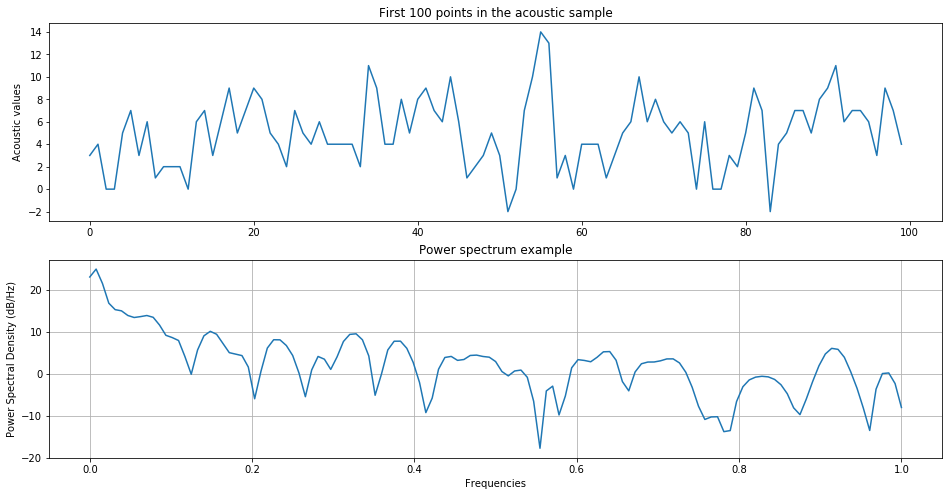

In [10]:
# a power spectrum example of the first 100 points in the acoustic sample
# peaks represent most impactful frequencies
sig = acoustic_sample[:100]
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8))
ax1.plot(np.arange(100), sig)
ax1.set_title('First 100 points in the acoustic sample')
ax1.set_ylabel('Acoustic values')
ax2.psd(sig)
ax2.set_title('Power spectrum example')
ax2.set_xlabel('Frequencies')
plt.show()

### Spectrogram
- A spectrogram attempts to find a middle ground between the time and frequency domain
- It bins up the signal and performs a fourier transform in each bin
- This allows us to know the frequency composition at different chunks of time
- There's an inherent tradeoff between time and frequency (smaller window --> more time info, less frequency info)

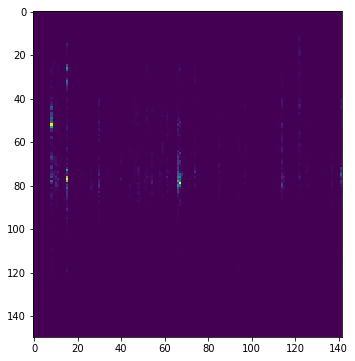

In [12]:
# an example of a spectrogram on the acoustic sample where every 1200 points are binnned
# notice that the green/yellow (high power) frequencies in the spectrogram roughly correspond where the main spikes
# occur in the acoustic sample (refer to the 13th notebook cell above)
_, _, sp = create_spectrogram(acoustic_sample, window_size=1200)
fig, ax = plt.subplots(figsize=(6, 6))
plt.imshow(sp)
plt.show()

### Wavelet Transform
- The wavelet transform is another approach to finding a middle ground between the time and frequency domain
- Instead of using fixed bins, the wavelet transforms slides a small, fixed-size signal (aka a wavelet) at different frequencies across the original signal
- Portions of the original signal that correlate strongly with the wavelet will result in larger dot produts for that moment in time
- As it turns out, this is equivalent to a convolution.
- What's neat about a one dimensional convolution is that the values of the kernel can be easily visualized as the wavelet itself (the kernel can be harder to visualize/interpret in 2D)
- The wavelet transform has a suite of common wavelet families that can be applied.
- Here's a great [blog](http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/) on the wavelet transform.

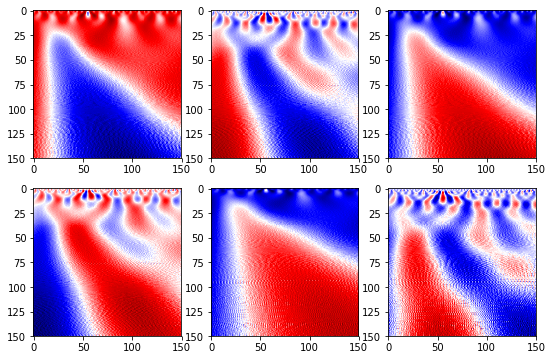

In [13]:
# Below are the results of applying six different wavelets to the acoustic sample
# During the wavelet transform, the wavelet is both stretches and slides across the original signal
# Since it varies across two different dimensions, the features it extracts can be visualized as images
# Here, the x axis is the time and the y axis is the frequency

scales = np.arange(1, 151)
wave_fams = ['cgau2', 'cgau7', 'gaus2', 'gaus7', 'mexh', 'morl']
spec_data = np.zeros((len(wave_fams), 150, 150))
i = 0
for wfam in wave_fams:
    coeff, _ = pywt.cwt(acoustic_sample, scales, wfam, 1)
    coeff = coeff[:, :150]
    spec_data[i] = np.real(coeff)
    i += 1
    
fig, axes = plt.subplots(2, 3, figsize=(9, 6))
for i in range(2):
    for j in range(3):
        axes[i, j].imshow(spec_data[i*3+j], cmap = plt.cm.seismic)
plt.show()

### Approach 5:
- For the next model, I made a deep learning model composed of two parts.
- The first submodel is the GRU in "Approach 4", except now the segmenter is modified to only return the excited segments, along with a measure of how much time has elapsed between these excited states.
- The second submodel is a 2D CNN that is passed over the spectrogram of the acoustic signal. I ended up choosing the spectrogram to measure the frequency component because it was much faster to calculate than the wavelet transform.
- Finally, the output vectors of the GRU and the spectrogram CNN are concatenated and passed through a fully connected network that predicts the remaining time.
- Validation loss: **1.61**

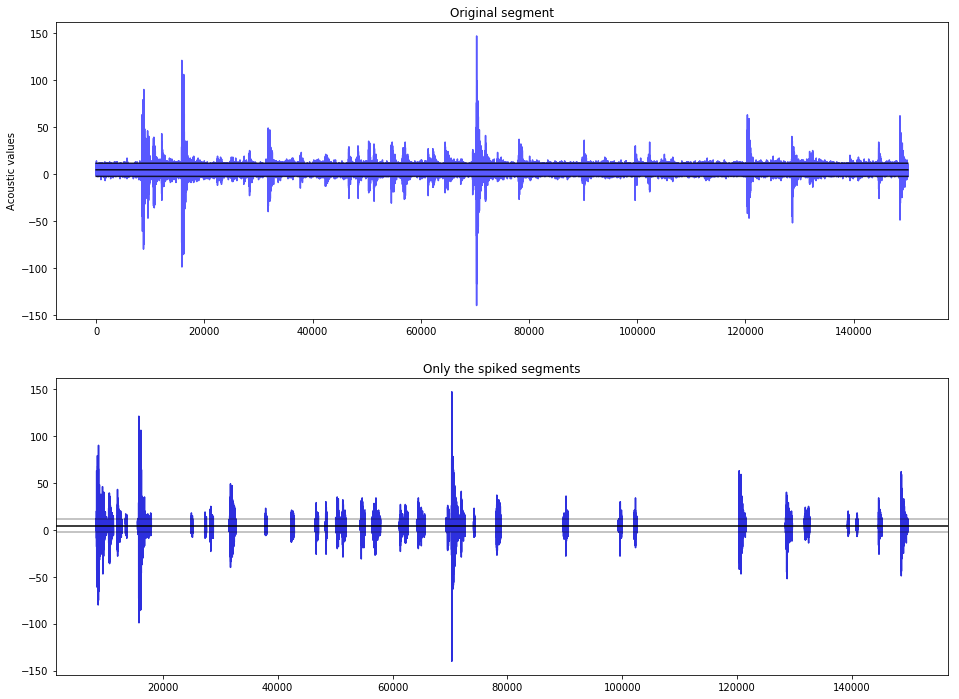

In [15]:
# define the segmenter to only return the excited segments
segmenter = SpikeSegmenter(mu=3.5, sigma=4.5, window_size=300, only_spikes=True)
cutoffs = segmenter(acoustic_sample)

# plot the raw signal with a mu +- 2*sigma margin
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))
ax1.plot(np.arange(150000), acoustic_sample, c='blue', alpha=0.65)
ax1.plot(np.arange(150000), 150000*[mu], c='black', alpha=0.9)
ax1.plot(np.arange(150000), 150000*[mu+2*sigma], c='black', alpha=0.8)
ax1.plot(np.arange(150000), 150000*[mu-2*sigma], c='black', alpha=0.8)
ax1.set_title('Original segment')
ax1.set_ylabel('Acoustic values')

# plot only the spikes in the acoustic signal
plot_segments(ax2, acoustic_sample, cutoffs, False, mu, sigma, alpha=0.3)
plt.title('Only the spiked segments')

plt.show()

### Approach 6:
- I still had a feeling that a 1D CNN could prove useful for this data.
- So, in the spirit of the previous model, I added the 1D CNN as a third submodel that operates on the entire 150000 acoustic sequence.
- Because I was using the entire sequence, I made the kernels larger, added more layers (which also led me to add batch normalization), and made the convolutions strided.
- The results of all three submodels were again concatenated and passed through a fully connected network.
- Validation score: **1.57**

### Final result
- My final L1 score on the Kaggle was **2.50674** (private test set), **2.26433** (public test set)
- It seems that a lot of the contestants had overfit models since their was a large shakeup in the leaderboard from the public to private leaderboard.
- I have reason to believe that my model was relatively general since the loss did not drastically increase.
- Unfortunately, my submission was past the deadline because I didn't realize that Kaggle operated on UTC...
- Based on my score I would have been **269th out of 4540 (bronze)**

### Lessons learned
- Intro to RNNs: I had great practice using pytorch for sequence modeling
- Intro to spectral analysis: This competition led me to learn a lot about frequency domain analysis
- Take part in discussions and kernels: Kaggle really is a great community of data scientists and taking part in the discussion can help you avoid writing boiler-plate code and can help you brainstorm new ideas.
- Submit early and often and try to wrap up all modeling efforts at least a day in advance **:)**